В этом ноутбуке пробуем кластеризацию терапевтических стратегий с помощью k-means

0. Написать функцию, которая принимает данные и выводит TSNE, сделать такой график для 3 датасетов - только T0,T0+вмешательства, только вмешательства.+ Для только T0 получилась классная кластеризация.
1. Добавить график - обоснование количества кластеров. Добавить информацию про кластера в датасет, и сохранить (с компонентами) для дальнейшей работы.+
2. Написать функцию, которая выводит график внутрикластерное расстояние к межкластерному (есть уже готовое) и дендрограмму, определить оптимальное количество кластеров (меньше - лучше для корреляций)
3. Погуглить можно ли считать корреляции Пирсона для непрерывных величин, если да то сделать ровно то что планировал.
4. Строю обычную байесовскую сеть для прогноза ЦП (или лучше динамическую), сначало с помощью blearn предсказываю категорию показателей прогресса (делю по межквартильным интервалам, считатю качество прогноза (accuracy для разных сетей, выбираю лучшую, отрисовываю и описываю.

In [1]:
#Imports moduls
%run "C:\Users\Илья\Desktop\Work\support_functions.ipynb"

Automatically created module for IPython interactive environment


In [2]:
df=pd.read_pickle("Data/mental_pats_for_modeling_T0_Last_Points_simple.pkl")

In [3]:
#Извлекаем данные для кластеризации
def get_data_for_clustering(df,non_intervention_features=['duration_treatment']):
    interventions=[c for c in df.columns if (':' in c)&(" : " not in c)&("Client" in c)]
    df=df[non_intervention_features] #interventions
     
    #Шкалируем duration_treatment чтобы расстояние искалось адекватней
    df=max_min_scale(df,non_intervention_features)
    return df

In [4]:
df.columns.to_list()

['T0_measurement_point_ID',
 'T0_client_ID',
 'T0_measurement_point',
 'T0_measurement_point_status',
 'T0_status_date',
 'T0_case_manager',
 'T0_age',
 'T0_WQO_quality_of_life',
 'T0_WQO_health_status',
 'T0_WQOLBR03',
 'T0_WQOLBR04',
 'T0_WQOLBR05',
 'T0_WQOLBR06',
 'T0_WQOLBR07',
 'T0_WQOLBR08',
 'T0_WQOLBR09',
 'T0_WQOLBR10',
 'T0_WQOLBR11',
 'T0_WQOLBR12',
 'T0_WQOLBR13',
 'T0_WQOLBR14',
 'T0_WQOLBR15',
 'T0_WQOLBR16',
 'T0_WQOLBR17',
 'T0_WQOLBR18',
 'T0_WQOLBR19',
 'T0_WQOLBR20',
 'T0_WQOLBR21',
 'T0_WQOLBR22',
 'T0_WQOLBR23',
 'T0_WQOLBR24',
 'T0_WQOLBR25',
 'T0_WQOLBR26',
 'T0_WQOLBRX1',
 'T0_WQOLBRX2',
 'T0_WQOLBRX3',
 'T0_BSI1801',
 'T0_BSI1802',
 'T0_BSI1803',
 'T0_BSI1804',
 'T0_BSI1805',
 'T0_BSI1806',
 'T0_BSI1807',
 'T0_BSI1808',
 'T0_BSI1809',
 'T0_BSI1810',
 'T0_BSI1811',
 'T0_BSI1812',
 'T0_BSI1813',
 'T0_BSI1814',
 'T0_BSI1815',
 'T0_BSI1816',
 'T0_BSI1817',
 'T0_BSI1818',
 'T0_ICF2_01',
 'T0_ICF2_02',
 'T0_ICF2_03',
 'T0_ICF2_04',
 'T0_ICF2_05',
 'T0_ICF2_06',
 'T0

In [5]:
#Диагнозы (при поступлении, без выявленных позже)
diagnosis=[c for c in df.columns if (re.match(r"[A-Z][0-9][0-9]",c)!=None)]

#Социальные признаки
social_features=["T0_age",'T0_gender : women','T0_gender : man']+[c for c in df.columns if "T0_referrer" in c] #+["duration_treatment"]
df["T0_age"]=df["T0_age"].astype(int)

non_intervention_features=diagnosis+social_features
df=get_data_for_clustering(df,non_intervention_features)

In [6]:
df

,G31,Z71,E03,I64,I23,E51,N40,F19,I26,E78,F14,D60,Z88,Z60,F11,I21,F21,Z81,E55,H55,J96,R26,R33,B22,G45,K63,M50,G21,J44,K14,Z22,J98,M25,B16,I82,R42,Q20,K59,F51,F50,M32,S00,F40,Z95,G47,Z64,F17,N80,Z90,K22,S06,Z93,G71,M51,R39,J45,Z98,F33,E05,R11,F24,M06,Z55,R00,M79,E28,R59,R32,D37,M54,H91,Z97,M89,F63,M07,L60,D32,M00,F23,M81,Z80,Z96,Z59,E07,I63,B18,D18,F92,Z72,I80,F12,Q75,E06,J34,C50,Z92,R10,Z21,E14,E10,K57,M42,R55,E66,R52,F20,Z56,E11,I48,X84,F25,Q86,Z75,Z58,G72,M24,H93,E87,Z65,H57,H53,D50,M76,F16,K02,J42,F64,G46,G93,F90,F84,F04,K76,Z76,F13,K51,I44,F30,H40,M17,F15,F60,Z63,F71,M41,N18,G40,K64,G90,Z86,F42,F07,B20,L03,I02,F61,I10,F41,M16,Z85,Z70,R51,F31,G35,F98,F82,K50,J20,K70,K92,Z91,M80,F88,Z94,M47,F06,F22,Z74,F34,Z83,N20,H81,F70,I05,Z73,G20,F45,F66,G44,R47,H50,R29,R63,F10,E68,Z87,E34,F38,G24,H00,F65,F62,F32,I87,A52,H25,Z62,G43,K29,F44,G25,K44,I25,F43,L28,P00,I89,M62,K08,G70,E73,Z61,T0_age,T0_gender : women,T0_gender : man,T0_referrer : Family/acquaintances,T0_referrer : Self,T0_referrer : Health insurance/PVA,T0_referrer : Psychologist/Psychotherapist,T0_referrer : Hospital,T0_referrer : Case Management,T0_referrer : Per ment internal,T0_referrer : Authority,T0_referrer : Other psychosocial institutions,T0_referrer : Established medical,T0_referrer : Other,T0_referrer : None
case_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743590,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Написать функцию, которая принимает данные и выводит TSNE, сделать такой график для 3 датасетов - только T0,T0+вмешательства, только вмешательства.

In [7]:
# #Ищу оптимальное количество кластеров (пока закоменчено)
# sse = []
# k_list = range(1, 15)
# for k in k_list:
#     km = KMeans(n_clusters=k)
#     km.fit(df)
#     sse.append([k, km.inertia_])
    
# oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
# plt.figure(figsize=(12,6))
# plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
# plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')

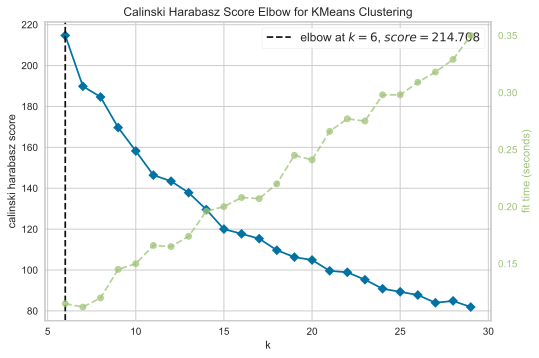

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
# Calinski Harabasz Score for K means
# # Calinski Harabasz Score for K means
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(6,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [9]:
#Выбираю количество кластеров
n_clusters=6

#Добавляем K-means кластеризацию, для более быстрой раскраски (в целом можно разделить по координатам, но оно нам не надо)
kmeans_scale = KMeans(n_clusters=n_clusters, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([df, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.13989915836133274


In [10]:
# # def show_TSNE(df)

# # np.random.seed(42)
# # rndperm = np.random.permutation(df.shape[0])


# # N = 6000
# df_subset = df.copy()
# data_subset = df_subset.values

# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(data_subset)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


# df_subset['tsne-2d-one'] = tsne_results[:,0]
# df_subset['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue=labels_scale, #параметр для обозначения кластера
#     palette=sns.color_palette("hls", n_clusters), #палитра для раскраски кластеров
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )

Explained variation per principal component: [0.16110299 0.08695758 0.05954381]


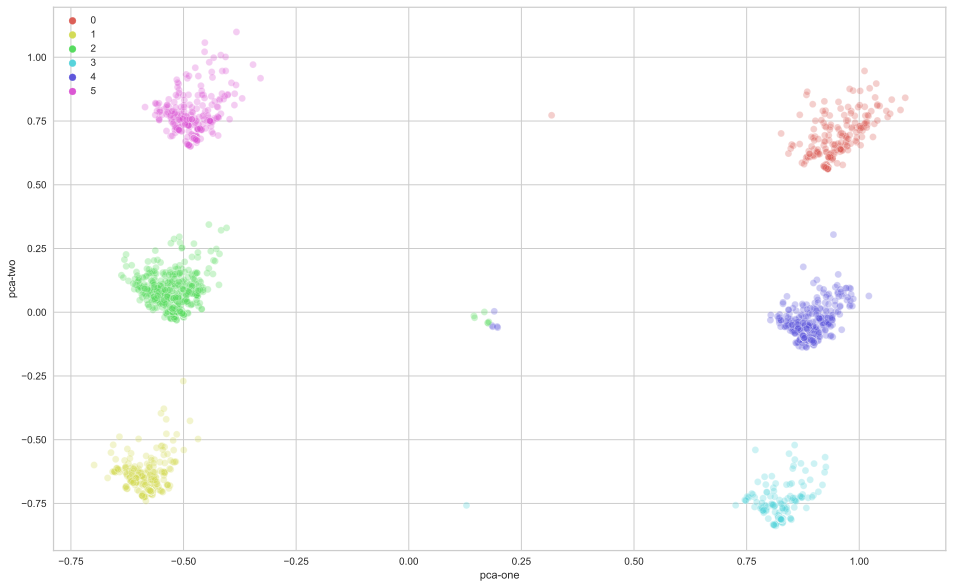

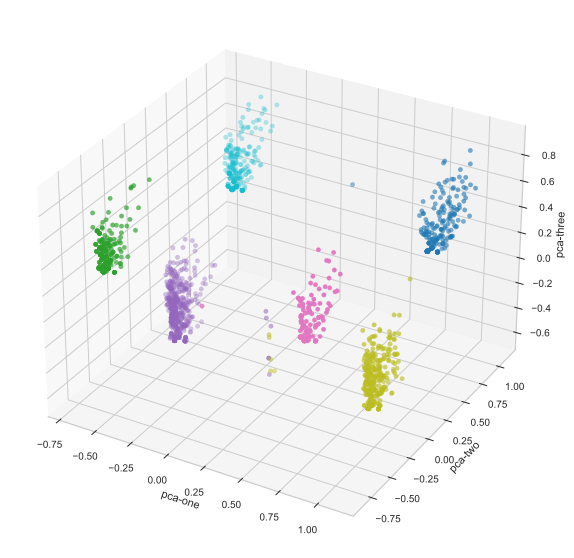

In [11]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df.values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=labels_scale, #параметр для обозначения кластера
    palette=sns.color_palette("hls", n_clusters), #палитра для раскраски кластеров
    data=df.copy(),
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=labels_scale, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [12]:
#Добавляем кластера
df['cluster']=labels_scale

In [13]:
#Для скопления точек в центре делаем свой, 7ой кластер
def fixing_clustering(df):
    # pca-one and pca two
    df.loc[(df['pca-one']>=0)&(df['pca-one']<=0.50)&(df['pca-two']<=0.25)&(df['pca-two']>=-0.25), 'cluster'] = 6
    df.loc[(df['pca-one']>=-0.75)&(df['pca-one']<=-0.25)&(df['pca-two']<=0.50)&(df['pca-two']>=-0.25), 'cluster']= 2

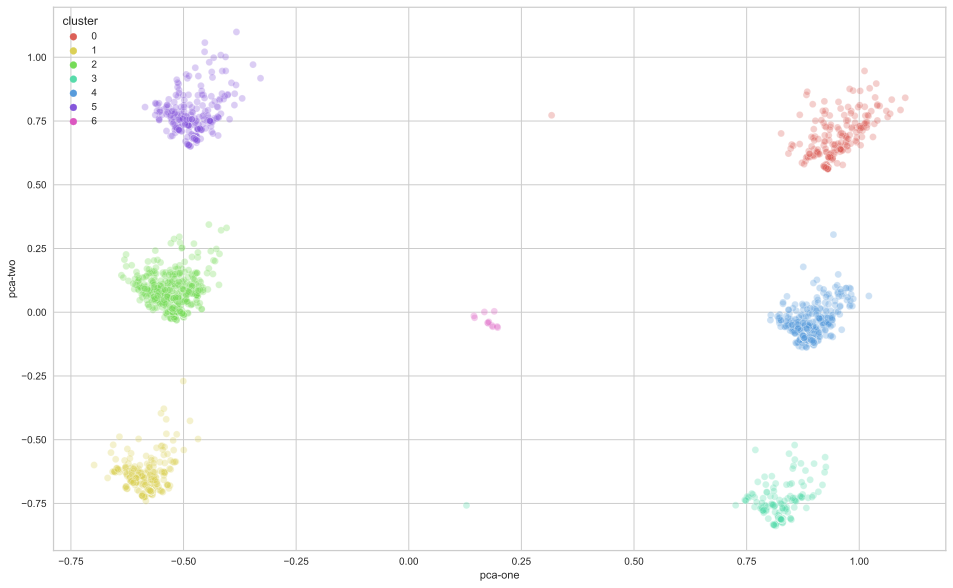

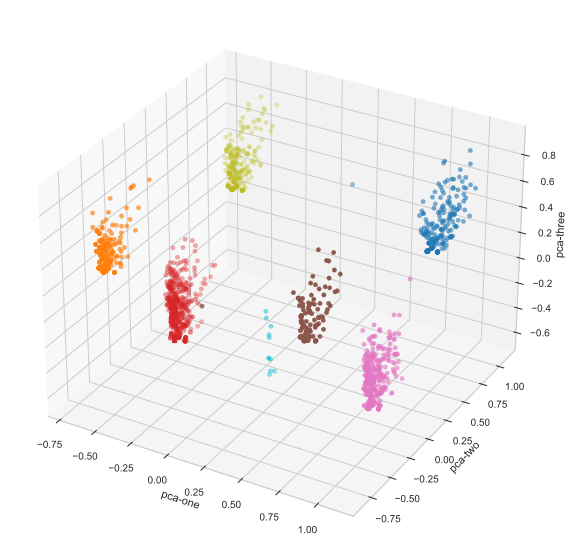

In [14]:
#Добавляем новый кластер и заново отрисовываем функцию

fixing_clustering(df)
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=df['cluster'], #параметр для обозначения кластера
    palette=sns.color_palette("hls", 7), #палитра для раскраски кластеров
    data=df.copy(),
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df['cluster'], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [15]:
#Добавляем информацию о кластеризации к начальному датасету и сохраняем
clustering_inform=df.iloc[:,-4:]
clustering_inform.to_pickle("Data/clustering_inform.pkl")
df=pd.read_pickle("Data/mental_pats_for_modeling_T0_Last_Points_simple.pkl")
df=df.join(clustering_inform)
df.to_pickle("Data/mental_pats_for_modeling_T0_Last_Points_simple_with_clustering.pkl")

<AxesSubplot:>

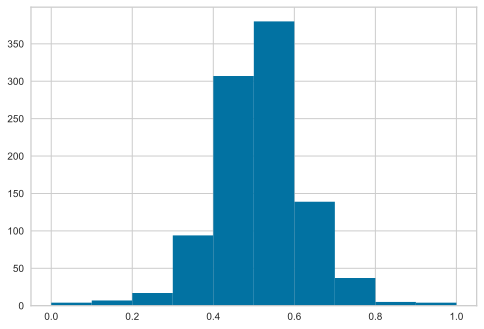

In [16]:
df['Mean progress for all indicators'].hist()

C всеми фичами визуализация получается интересной, даже очень. Особенно трехмерные главные компоненты.
Без вмешательств (только соц признаки и диагнозы - лучший результат, правда с длительностью лечения, вообще отличный, четчайшая визуализация кластеров, что говорит о наличии очень четкой структуры), круто что без длительности ничего не изменилось.

In [17]:
# from __future__ import print_function
# import time
# import numpy as np
# import pandas as pd
# from sklearn.datasets import fetch_openml
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# %matplotlib inline
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns

# mnist = fetch_openml("mnist_784")
# X = mnist.data / 255.0
# y = mnist.target

# feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
# df = pd.DataFrame(X,columns=feat_cols)
# df['y'] = y
# df['label'] = df['y'].apply(lambda i: str(i))
# X, y = None, None


# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(df[feat_cols].fillna(0).values)
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df.loc[rndperm,:],
#     legend="full",
#     alpha=0.3
# )


In [18]:
# # For reproducability of the results
# np.random.seed(42)
# rndperm = np.random.permutation(df.shape[0])


# N = 10000
# df_subset = df.loc[rndperm[:N],:].copy()
# data_subset = df_subset[feat_cols].fillna(0).values
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(data_subset)
# df_subset['pca-one'] = pca_result[:,0]
# df_subset['pca-two'] = pca_result[:,1] 
# df_subset['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(data_subset)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


# df_subset['tsne-2d-one'] = tsne_results[:,0]
# df_subset['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )

In [19]:
# # Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# visualizer.fit(df)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure